
# PA ST 807: Convolutional Neural Network
## Homework 1: Artificial Neural Networks, Model Interpretation, and Regularization

**GEC**<br/>
**Instructor**: Pavlos Protopapas<br />
**Maximum Score**: 100

<hr style="height:2.4pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

### Names of the people who worked on this homework together
#### /name here/

<a id="contents"></a>

## Notebook Contents

- [**PART 1 [50 pts]: Model interpretation and predictive intervals in NN**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [50 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


---

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
<h1> PART 1 [50 pts]: Model interpretation and predictive intervals in NN </h1> 

<br />


<a id="part1intro"></a>

<b> Overview and Data Description </b>
<br /><br />
[Return to contents](#contents)
<br />
In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival based on features that could be measured as the flight takes off.  
We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.  


The included variables are:
<br /><br />
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).
<br /><br />
**DISTANCE**: the distance between arrival and departure airports, in miles.
<br /><br />
**SCHEDULED_TIME**: the flight's scheduled travel time.
<br /><br />
**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.
<br /><br />
**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).
<br /><br />
**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).
<br /><br />
**FLIGHT_COUNT**: the number of flights flying out of that airport before noon on a typical day.
<br /><br />
**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.
<br /><br />
**ORIGIN_AIRPORT**: the airport the flight took off from.
<br /><br />
**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.
<br /><br />
For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.
<br /><br />
**NOTE:** The observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

</div> 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART 1: Questions</h2> 
<br /><br />
    
[Return to contents](#contents)

<br /><br />
**1.1.1 [5 points]**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater than or equal to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 
<br /><br />
**1.1.2 [5 points]** Preprocess the data: one-hot-encode the non-numeric categorical variables, deal with missing values if there are any, scale your data, and split the data into training and test sets (use an 80/20 split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
<br /><br />
**1.2 [5 points]** Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use appropriate activation functions for each layer, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for an appropriate number of epochs based on the results of your training and validation accuracy plot, and feel free to use the default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.
<br /><br />
**1.3 [10 points]** To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` training predictions.

<br /><br />
- **1.3.1** For this we need to modify our training set. First, generate a set of `NN_model` class predictions for the training set. These training predictions will be used to form a revised training dataset for our proxy model: (a) use all of the same $X$ values used by `NN_model` for our $X$ train and (b) replace the actual response values $y$ with the predicted $\hat{y}$ values generated by the fitted `NN_model`.

<br /><br />
- **1.3.2** Next, fit a logistic regression model using your revised training dataset from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

<br /><br />
- **1.3.3** Now use sklearn's `permutation_importance` class (already included in this notebook's imports) to compute the feature importance using the `logreg` model.
<br />
  - Read the official documentation for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.) as well as [here](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) to learn how it works.
<br />
  - You can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.
<br />
  - Measure the **relative** variable importance (i.e. as a proportion of the variable importance of the most important variable identified by `permutation_importance`) and generate a barplot illustrating the relative variable importances for the top-10 most important predictors identified using `permutation_importance`.
<br /><br />

**1.4 [10 points]** Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. 
<br /><br />

   - **1.4.1** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.
<br /><br />
 
   - **1.4.2** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

<br /><br />
   - **1.4.3**   Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.

<br /><br />
   - **1.4.4** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 
<br /><br />

  - **1.4.5** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
<br /><br />
**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your datapoints based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.
<br /><br />
    
**1.5 [5 points]**
    
<br /><br />
In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 
<br /><br />
Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% CI bounds clearly marked and reported in each subplot and the actual class of each observation included in each subplot's title for easy reference.
    <br /><br />
Interpret what you see in 3-5 sentences.
<br /><br />
    
**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the provided `progressbar` function below to visually track the progress of your bootstraps.
    
<br /><br />
    
**1.6 [10 points]**
    
<br /><br />
Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.
<br /><br />
To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).
<br /><br />
Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)
<br /><br />
Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.
<br /><br />
- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 
<br /><br />
- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.
<br /><br />
- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.
<br /><br />
- Interpret what you see in 3-5 sentences.
<br /><br />
    
**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<div class='exercise-r'>  

**1.1**

</div>

In [3]:
# Read in the dataset flights.csv. Create a variable DELAY_OR_NOT that denotes whether ARRIVAL_DELAY is greater than or equal to 15 minutes 
# (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the 
# rest of this question.
dataset = pd.read_csv('flights.csv')
DELAY_OR_NOT = dataset['ARRIVAL_DELAY']
DELAY_OR_NOT = [1 if i >=15 else 0 for i in DELAY_OR_NOT]

<div class='exercise-r'>  

**1.1.2**
    
</div>

In [4]:
# Preprocess the data: one-hot-encode the non-numeric categorical variables, deal with missing values if there are any, 
# scale your data, and split the data into training and test sets (use an 80/20 split with random_state=111). 
# Print the resulting shapes of your  𝑋  and  𝑦  dataframes for both your train and your test sets.

# def functions for futher usage
def generate_training_set():
    # Change the Origin Airport and Destination Airport into One-hot code, the unmatched number will be considered as one type to make sure the integrity of data
    ORIGIN_AIRPORT=dataset['ORIGIN_AIRPORT']
    ORIGIN_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in ORIGIN_AIRPORT ]
    ORIGIN_AIRPORT = pd.get_dummies(ORIGIN_AIRPORT).values
    DESTINATION_AIRPORT=dataset['DESTINATION_AIRPORT']
    DESTINATION_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in DESTINATION_AIRPORT ]
    DESTINATION_AIRPORT = pd.get_dummies(DESTINATION_AIRPORT).values

    # Change Date of Week and Month into One-hot code as well
    DAY_OF_WEEK=dataset['DAY_OF_WEEK']
    DAY_OF_WEEK = pd.get_dummies(DAY_OF_WEEK).values
    MONTH = dataset['MONTH']
    MONTH=pd.get_dummies(MONTH).values
    # Using StandardScaler to do normalization with column DISTANCE, FLIGHT_COUNT, and SCHEDULED_TIME
    scalar=StandardScaler()
    DISTANCE=dataset['DISTANCE'].values.reshape(-1,1)
    SCHEDULED_TIME=dataset['SCHEDULED_TIME'].values.reshape(-1,1)
    FLIGHT_COUNT=dataset['FLIGHT_COUNT'].values.reshape(-1,1)
    scalar.fit(DISTANCE)
    DISTANCE=scalar.transform(DISTANCE)
    scalar.fit(SCHEDULED_TIME)
    SCHEDULED_TIME=scalar.transform(SCHEDULED_TIME)
    scalar.fit(FLIGHT_COUNT)
    FLIGHT_COUNT=scalar.transform(FLIGHT_COUNT)

    # Also extract SCHED_DEP_HOUR and SCHED_ARR_HOUR, and convert them into One-hot 
    SCHED_DEP_HOUR= dataset['SCHED_DEP_HOUR']
    SCHED_ARR_HOUR =dataset['SCHED_ARR_HOUR']
    SCHED_DEP_HOUR = pd.get_dummies(SCHED_DEP_HOUR).values
    SCHED_ARR_HOUR = pd.get_dummies(SCHED_ARR_HOUR).values

    # Assemble all predictors together as X, and DELAY_OR_NOT values as Y. Splitting train and test daatsets according to the requirement.
    X=np.hstack([DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT])
    y=np.array(DELAY_OR_NOT)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
    print('X_train shape: {X_train_shape},\ny_train shape: {y_train_shape},\nX_test shape: {X_test_shape},\ny_test shape: {y_test_shape}'.format(X_train_shape=X_train.shape,y_train_shape=y_train.shape,X_test_shape=X_test.shape,y_test_shape=y_test.shape))
    return  X_train, X_test, y_train, y_test

<div class='exercise-r'>  
    
**1.2**
    
</div>

In [5]:
#Construct the model following the instruction, also use adagrad as Optimizer, since so much sparce data here
NN_model = tf.keras.Sequential(name='NN_model')
NN_model.add(tf.keras.layers.Dense(units=15,activation='elu'))
NN_model.add(tf.keras.layers.Dense(units=15,activation='elu'))
NN_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
NN_model.compile(optimizer='adagrad',loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])
NN_model.build(input_shape=((64,620)))

In [6]:
# Shuffle the data and aslo add EarlyStop callback with patience = 10NN_model
EarlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
X_train, X_test, y_train, y_test = generate_training_set()
history = NN_model.fit(X_train,y_train,verbose=1,batch_size=64,validation_split=0.2,epochs=500,shuffle = True,callbacks=[EarlyStop])

X_train shape: (8000, 620),
y_train shape: (8000,),
X_test shape: (2000, 620),
y_test shape: (2000,)
Epoch 1/500
100/100 [==============================] - 2s 5ms/step - loss: 0.6882 - accuracy: 0.5503 - val_loss: 0.6853 - val_accuracy: 0.5506
Epoch 2/500
100/100 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5670 - val_loss: 0.6803 - val_accuracy: 0.5788
Epoch 3/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5794 - val_loss: 0.6759 - val_accuracy: 0.5900
Epoch 4/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5878 - val_loss: 0.6719 - val_accuracy: 0.5969
Epoch 5/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5987 - val_loss: 0.6682 - val_accuracy: 0.6112
Epoch 6/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6058 - val_loss: 0.6647 - val_accuracy: 0.6175
Epoch 7/500
100/100 [====================

Text(0.5, 0.98, 'Model Training')

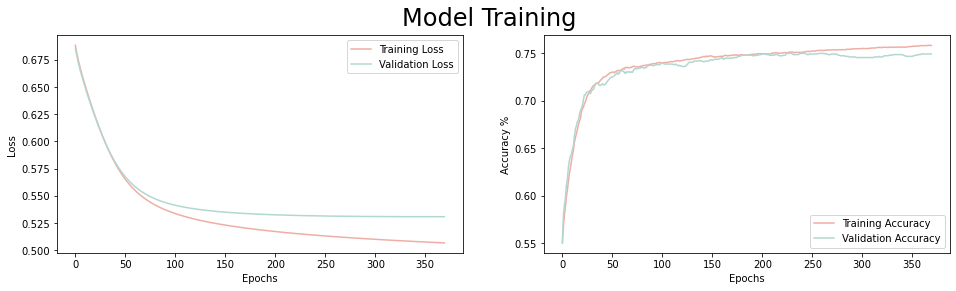

In [7]:
# plot train and val acc as  a function of epochs
# your code here
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Model Training', fontsize = 24)

In [8]:
# primer to print: 
# print("NN_model_train_auc:", roc_auc_score(y_train, y_hat))
# your code here 
y_hat=NN_model.predict(X_train)
print("NN_model_train_auc:", roc_auc_score(y_train,y_hat ))

NN_model_train_auc: 0.825918494763246


In [9]:
# your code here
y_hat_test=NN_model.predict(X_test)
print("NN_model_train_auc:", roc_auc_score(y_test,y_hat_test ))

NN_model_train_auc: 0.8049159679418624


<div class='exercise-r'>

**1.3**

</div>

D:\ENV\Anaconda\envs\tfenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\ENV\Anaconda\envs\tfenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic_Regression_auc: 0.7363522313340183


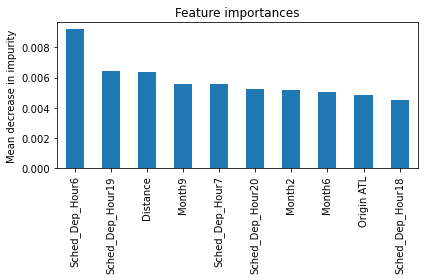

In [10]:
logreg=LogisticRegression(penalty='l2',C=5).fit(X_train,np.around(y_hat,0))
log_y_hat=logreg.predict(X_test)
print("Logistic_Regression_auc:", roc_auc_score(y_test,log_y_hat ))

result = permutation_importance(logreg, X_test, y_test, n_repeats=40,random_state=0,n_jobs=-1)

# Helper to get the index name
# Genersating names of  training data, by each category
name_list=[]
name_list.append('Distance')
name_list.append('Scheduled Time')
for i in range(1,13):
    name_list.append('Month'+str(i))
for i in range(0,24):
    name_list.append("Sched_Dep_Hour"+str(i))
name_list.remove('Sched_Dep_Hour3')
for i in range(0,24):
    name_list.append("Sched_Arr_Hour"+str(i))
name_list.append('Flight Count')
for i in range(1,8):
    name_list.append("Weekday"+str(i))
ORIGIN_AIRPORT=dataset['ORIGIN_AIRPORT']
ORIGIN_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in ORIGIN_AIRPORT ]
ORIGIN_AIRPORT = pd.get_dummies(ORIGIN_AIRPORT)
columns = ORIGIN_AIRPORT.columns.values.tolist()
for i in columns:
    name_list.append("Origin "+i)  
DESTINATION_AIRPORT=dataset['DESTINATION_AIRPORT']
DESTINATION_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in DESTINATION_AIRPORT ]
DESTINATION_AIRPORT = pd.get_dummies(DESTINATION_AIRPORT)
columns = DESTINATION_AIRPORT.columns.values.tolist()
for i in columns:
    name_list.append("Destination "+i)
    
# Get top 10 importance index
list1=result.importances_mean.copy()
list1.sort()
list11=list1[::-1]

# Create list for barchart
chart_x=[]
chart_value=[]
for i in list11[0:10]:
    chart_x.append(name_list[int(np.argwhere(result.importances_mean==i))])
    chart_value.append(i)
top10_importances=pd.Series(chart_value,index=chart_x)

#Draw barchart
fig, ax = plt.subplots()
top10_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<div class='exercise-r'>

**1.4**    

**1.4.1**

</div>

In [11]:
# your code here


**INTERPRETATION:**

*Your answer here*

<div class='exercise-r'>

**1.4.2**
</div>

In [12]:
# your code here


<div class='exercise-r'>

**1.4.3**
    
</div>

In [13]:
# your code here


<div class='exercise-r'>

**1.4.4**
    
</div>

In [14]:
# your code here


**INTERPRETATION:**

*your answer here*

<div class='exercise-r'>

**1.5**

</div>

In [15]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()
# Helper to get the index name
# Genersating names of  training data, by each category
name_list=[]
name_list.append('Distance')
name_list.append('Scheduled Time')
for i in range(1,13):
    name_list.append('Month'+str(i))
for i in range(0,24):
    name_list.append("Sched_Dep_Hour"+str(i))
name_list.remove('Sched_Dep_Hour3')
for i in range(0,24):
    name_list.append("Sched_Arr_Hour"+str(i))
name_list.append('Flight Count')
for i in range(1,8):
    name_list.append("Weekday"+str(i))
ORIGIN_AIRPORT=dataset['ORIGIN_AIRPORT']
ORIGIN_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in ORIGIN_AIRPORT ]
ORIGIN_AIRPORT = pd.get_dummies(ORIGIN_AIRPORT)
columns = ORIGIN_AIRPORT.columns.values.tolist()
for i in columns:
    name_list.append("Origin "+i)  
DESTINATION_AIRPORT=dataset['DESTINATION_AIRPORT']
DESTINATION_AIRPORT= [ 'Unknown' if x.isdigit() else x for x in DESTINATION_AIRPORT ]
DESTINATION_AIRPORT = pd.get_dummies(DESTINATION_AIRPORT)
columns = DESTINATION_AIRPORT.columns.values.tolist()
for i in columns:
    name_list.append("Destination "+i)

In [16]:
%%time
# Bootstrap and train your networks and get predictions on fixed X test
# your code here
X_train, X_test, y_train, y_test = generate_training_set()
y_train=y_train[:,np.newaxis]

# Function that does Bootstrap sampling, using resample model from scikit-learn 
def bootstrap(dataset_size):
    # TODO: Validate the accuracy of these codes, especially for the boot data size
    boot = resample(np.hstack([X_train,y_train]), replace=True, n_samples=dataset_size, random_state=1)
    boot_x=boot[:,:620]
    boot_y=boot[:,-1].reshape(1,-1)
    return boot_x,boot_y

# Function that reconstructs the model and performs training, returns the training histories and predictions over test samples
# The training strategy is the same as process in 1.2 above

def gaining_models(X_train,y_train):
    NN_model = tf.keras.Sequential(name='NN_model')
    NN_model.add(tf.keras.layers.Dense(units=15,activation='elu'))
    NN_model.add(tf.keras.layers.Dense(units=15,activation='elu'))
    NN_model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
    NN_model.compile(optimizer='adagrad',loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])
    NN_model.build(input_shape=((64,620)))
    EarlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    X_train,y_train = bootstrap(dataset_size=8000)
    y_train=y_train.reshape(-1,1)
    history = NN_model.fit(X_train,y_train,verbose=0,batch_size=64,validation_split=0.2,epochs=500,shuffle = True,callbacks=[EarlyStop])
    prediction=NN_model.predict(X_test)
    return history,prediction

results=[]
predictions=[]

# Do training over Bootstrapped data and models
for i in range(0,100):
    x_train_bs,y_train_bs=bootstrap(dataset_size=X_train.shape[0])
    result,prediction=gaining_models(x_train_bs,y_train_bs)
    results.append(result)
    predictions.append(prediction)
    progressbar(i,100)

X_train shape: (8000, 620),
y_train shape: (8000,),
X_test shape: (2000, 620),
y_test shape: (2000,)
 [==================================================] 100/100 Done...

Wall time: 3h 52min 44s


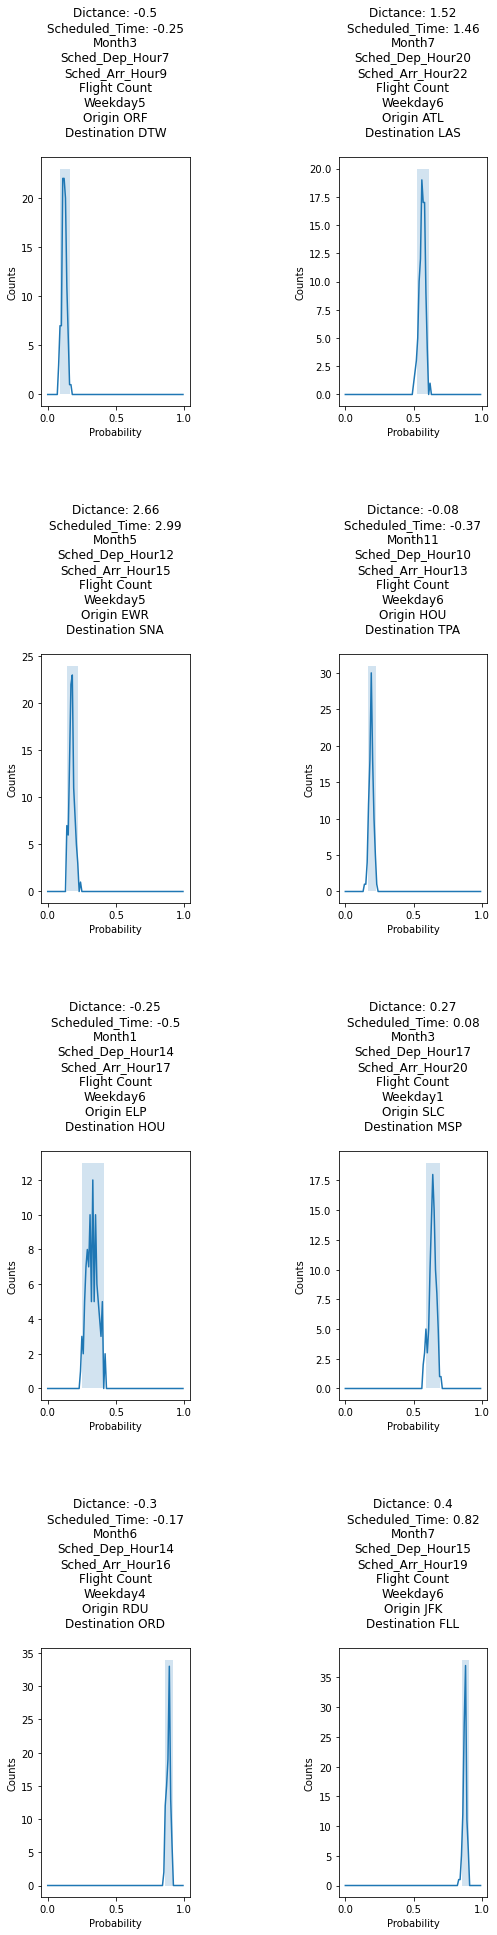

In [17]:
# generate your plot

#import scipy , using scipy.stats.norm.interval function to calculate the Condidence Interval
import scipy

# Function that randomly select data from test set, generate mean values, std values and values of predictions of those chosen data
# returns the frequency of probabilities distributions of the chosen test data
def generat_random_data(size):
    random_choice=np.random.randint(low=0,high=X_test.shape[0],size=8)
    prob_list=[]
    mean_list=[]
    std_list=[]
    for i in random_choice:
        probability=[]
        for j in predictions:
            probability.append(j[i])
        probability=np.squeeze(np.array(probability))
        prob=np.zeros(100)
        for i in probability:
            prob[int(i*100)]+=1
        prob_list.append(prob)
        mean_list.append(np.mean(probability))
        std_list.append(np.std(probability))
    return prob_list,random_choice,mean_list,std_list

results,choices,means,stds=generat_random_data(8)

# plot all frequency of distribution
plt.figure(figsize=(8,32))
for i in range(1,9):
    choice=X_test[choices[i-1]]

    # Get all index of the test data, whose value is not zero, 
    # using name_list generated above to get the original values of data in the test set,
    # and eventually set those values as the charts' titles
    index=np.argwhere(choice!=0)
    index=np.squeeze(index)
    title_str='Dictance: '+str(round(choice[0],2))+'\nScheduled_Time: '+str(round(choice[1],2))+'\n'
    for k in range(2,len(index)):
        title_str=title_str+name_list[index[k]]+"\n"

    # Calculate the left and right boundary of the 95% CI region using Scipy
    # Plot all data
    left_mark,right_mark=scipy.stats.norm.interval(0.95,loc=means[i-1],scale=stds[i-1])
    ax=plt.subplot(420+i)
    plt.plot(np.arange(0,100,1)/100,results[i-1])
    plt.fill_between([left_mark,right_mark],0,np.max(results[i-1])+1,alpha=0.2)
    ax.set_title(title_str)
    plt.xlabel("Probability")
    plt.ylabel('Counts')
    plt.subplots_adjust(wspace=1,hspace=1)


**INTERPRETATION:**

It seems that the distribution of all chosen bootstrapped samples are Gaussian Distribution. 

The center of the counts probability is the mean value of the probability, and the CI, which covers 95% of the probability distribution also resembles to the Gaussian Distribution.
 
And almost all of the mean value nears 0.5.


<div class='exercise-r'>

**1.6**

</div>

In model 1, the accuracy over test data is 0.8012393465518295
In model 2, the accuracy over test data is 0.8024268702497802
In model 3, the accuracy over test data is 0.7999717875583132
In model 4, the accuracy over test data is 0.8011703161094041
In model 5, the accuracy over test data is 0.801000241106328
In model 6, the accuracy over test data is 0.802401859219916
In model 7, the accuracy over test data is 0.8013153800826164
In model 8, the accuracy over test data is 0.8024398759853095
In model 9, the accuracy over test data is 0.8005640487454968
In model 10, the accuracy over test data is 0.8029300921706473
In model 11, the accuracy over test data is 0.8005985639667093
In model 12, the accuracy over test data is 0.8000588259422405
In model 13, the accuracy over test data is 0.803667417331043
In model 14, the accuracy over test data is 0.8034963418867721
In model 15, the accuracy over test data is 0.8040395814554218
In model 16, the accuracy over test data is 0.8024808940742867
In m

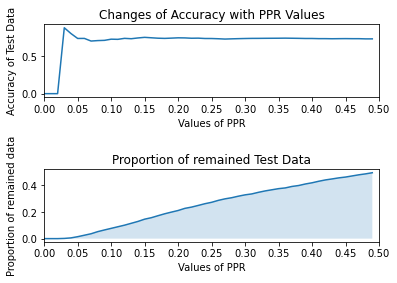

In [27]:
# your code here
all_predicts=np.squeeze(np.array(predictions.copy())).T
pprs=np.zeros(all_predicts.shape[0])
for i in range(0,all_predicts.shape[0]):
    temp=all_predicts[i]
    one=np.sum(temp)
    zero=temp.shape[0]-one
    ppr=min(one/temp.shape[0],zero/temp.shape[0])
    pprs[i]=ppr    
    
for i in range(0,all_predicts.shape[1]):
    print(f'In model {i+1}, the accuracy over test data is {roc_auc_score(y_test,all_predicts.T[i])}')

def abstain_bagging_model(PPR_values):
    alter_predictions,alter_y_test=all_predicts.copy(),y_test.copy()
    alter_pprs=pprs.copy()
    remain=0
    for i in range(0,pprs.shape[0]):
        if(pprs[i]>PPR_values):
            inedx = np.argwhere(alter_pprs==pprs[i])
            #print(i,index[0])
            alter_y_test=np.delete(alter_y_test,index[0])
            alter_predictions=np.delete(alter_predictions,index[0],0)
            alter_pprs=np.delete(alter_pprs,index[0])
    abstain_predicts=np.zeros(alter_y_test.shape[0])
    for i in range(0,alter_y_test.shape[0]):
        temp=np.sum(alter_predictions[:][i])
        # print(temp,alter_predictions.shape[1]/2)
        if temp>(alter_predictions.shape[1]/2):
            # print('YES')
            abstain_predicts[i]=1
            remain+=1
    if(abstain_predicts.shape[0]<=1):
        # print(f'PPR {PPR_values} too large or too small, no observations remain!')
        return 0,remain
    # for i in abstain_predicts:
    #     print(i)
    return roc_auc_score(alter_y_test,abstain_predicts),remain

auc_scores=np.zeros(50)
remains=np.zeros(50)
for i in range(0,50):
    auc_scores[i],remains[i]=abstain_bagging_model(i/100)
x_label=np.arange(0,50)/100
x_ticks=np.arange(0,55,5)/100
plt.subplot(211)
plt.plot(x_label,auc_scores)
plt.xlim(0,0.5)
plt.xticks(x_ticks)
plt.xlabel('Values of PPR')
plt.ylabel('Accuracy of Test Data')
plt.title('Changes of Accuracy with PPR Values')

plt.subplot(212)
plt.title('Proportion of remained Test Data')
plt.xlabel('Values of PPR')
plt.ylabel('Proportion of remained data')
plt.xlim(0,0.5)
plt.xticks(x_ticks)
plt.fill_between(x_label,0,remains/all_predicts.shape[0],alpha=0.2)
plt.plot(x_label,remains/all_predicts.shape[0])
# plt.fill_between([0,0.5],remains,1,alpha=0.2)
plt.subplots_adjust(wspace=1,hspace=1)      
        

**INTERPRETATION:**

Clearly, with the increase of PPR value, more and more data would be taken into consideration.

Also, the accuracy of the *Abstained* values seem to decrease with the increase of PPR from the point where the size of remained data is not zero.

Moreover, from discussio with Mentors in fourm, I came to understand that the data, which remained, is what the NN model has confident to predict.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">


<h1>PART 2 [50 pts]: Kannada MNIST</h1>
<br /><br />
[Return to contents](#contents)
<br /><br />

<a id="part2intro"></a>
<h2> Problem Statement </h2>
<br /><br />
[Return to contents](#contents)
<br /><br />

ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.
<br /><br />
There are several methods used to improve ANN generalization. 
<br /><br />
One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.
<br /><br />
However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".
<br /><br />
In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>
<br /><br />
<h3> The Kannada MNIST Dataset </h3>
<br /><br />
[Return to contents](#contents)
<br /><br />

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)

<br /><br />
For this problem, we will be working with a modified version of [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf) , which is a large database of handwritten digits in the indigenous language *Kannada*.
<br /><br />
This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 
<br /><br />
For this homework, we will simplify the problem by only use the digits labeled `0` and `1` owing to the similarity of the two symbols, and we want to use a total of 1200 samples for training (this includes the data you will use for validation).
<br /><br />
To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.
<br /><br />
<a id="part2data"></a>

<h4> Downloading the Data Files </h4>
<br />
[Return to contents](#contents)
<br />
Please download all files from resources on Ed.
<br /><br />
Here's a brief description of the available files:
<br /><br />
- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.
<br /><br />
Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada language.  
<br />
- `kmnist_test.csv` has a structure similar to `kmnist_train.csv` but you will use this only for testing.
    
</div>    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART2 Questions</h2>
<br /><br />
[Return to contents](#contents)

<br /><br />
**2.1 [5 points]** **Get the data:**

- Download data from Ed resources.
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1.
<br /><br />
    
**2.2 [15 points]** **Overfit an ANN:** 

Build a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: no more than 2,000
- Batch size: 128
- Validation size: 0.3

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="part2_3"></a>
<br /><br />

**2.3 [30 points]** **Regularize overfit network:**

Create an ANN that doesn't overfit and report your accuracy on the test set.
<br /><br />
**DON'TS**

**Don't change the architecture**. In other words, keep the number of layers, number of nodes, activation function,  loss function and output unit the same. **No CNNs/RNNs/enhancements.**

<br />
    
**NOTE**: We strongly discourage you to use a different training set than the one provided to you but data augmentation is allowed. 

<br /><br />
    
**DOS**

You can change the number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize (e.g., dropout, L2 norm, etc.). You can also do data augmentation. 
<br /><br />

- **2.3.1** Display your model summary and your training and validation accuracy and loss.

<br />
    
- **2.3.2** Print the difference between the training and validation accuracies and the difference between the training and validation losses for the final trained epoch used by your model.

<br />
    
- **2.3.3** Plot the training accuracy and validation accuracy as a function of epochs.
<br />

- **2.3.4** Once your model is trained, evaluate your model on the test dataset and provide the test accuracy.


<br /><br />

</div>

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<div class='exercise-r'>

**2.1** 
    
</div>

In [19]:
# your code here 

<div class='exercise-r'>

**2.2**
    
</div>

In [20]:
# your code here

**INTERPRETATION:**

*your answer here*

<div class='exercise-r'>

**2.3** 

**2.3.1**
    
</div>

In [21]:
# your code here

<div class='exercise-r'>

**2.3.2**
    
</div>

In [22]:
# your code here

<div class='exercise-r'>

**2.3.3**
    
</div>

In [23]:
# your code here

<div class='exercise-r'>

**2.3.4**
    
</div>

In [24]:
# your code here